# Adaptive Noise Cancellation

Doctor, in trying to review the electroencephalogram (EEG) of a distracted graduate student, finds that the signal he would like to see has been contaminated by a 60-Hz noise source. He is examining the patient on-line and wants to view the best signal that can be obtained.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from keras import models
from keras import layers
from keras import optimizers


# Obtain the pure EEG Signal $S(k)$ from the data file _Data_EEG.txt_


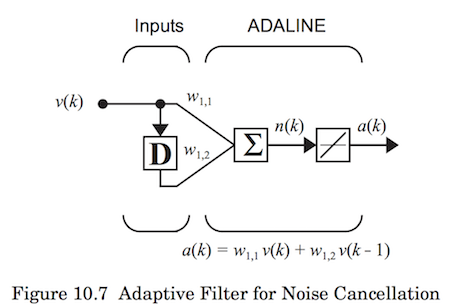

In [2]:
# Architecture of ADALINE of order 1:

from IPython.display import Image
Image("Adaline_Adaptive_Filter.png")


In [3]:
S = np.loadtxt('Data_EEG.txt', skiprows=1, unpack=True)
S_sqr = np.square(S)
Mean_S_sqr = np.mean(S_sqr)
n = len(S)


# Create the unfiltered signal $t(k)=S(k)+m(k)$

- $S(k)$: is the **pure EEG signal**
- $v(k)$: is the sampled sinusoidal electrical network signal (three times in a period) and considered as the input signal to ADALINE network and its output
- $m(k)$: is the noisy signal comming from the electrical network.
- $t(k)$: is the unfiltered signal (t(k)=S(k)+m(k))
- $a(k)$: is the estimation of the noisy signal m(k).
- plot the pure signal $S(k)$ and unfiltered signal $T(k)$ in order to evaluate the filtering operated by ADALINE network.


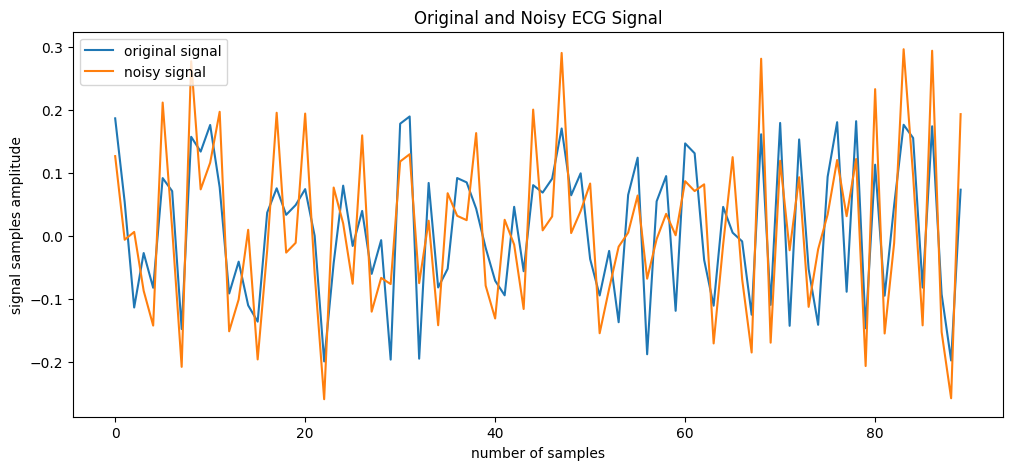

In [4]:
v = []
m = []
for i in range(30):
    v = np.concatenate((v, [1.2*np.sin(2*np.pi*(1/3)), 1.2 *
                       np.sin(2*np.pi*(2/3)), 1.2*np.sin(2*np.pi*(3/3))]))
    m = np.concatenate((m, [0.12*np.sin((2*np.pi*(1/3))+np.pi/2), 0.12*np.sin(
        (2*np.pi*(2/3))+np.pi/2), 0.12*np.sin((2*np.pi*(3/3))+np.pi/2)]))

# Contaminated output signal
t = S+m
# ..........................
plt.figure(1, figsize=(12, 5))
plt.plot(S)
plt.plot(t)
plt.legend(('original signal', 'noisy signal'), loc='upper left')
plt.title('Original and Noisy ECG Signal')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()


# Filter Order Selection

ADALINE output $a(t)$ may be calculated based on:

- a first order model given in the figure using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$
- a second order model given by the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$

where the order is the number of retarded inputs signals used as input to neural network.


# First Order Filter Design: Optimal Solution

- The optimal solution is obtained by minimizing **least mean square** (LMS) between
  the unfiltered signal T(k) and the output of the second order filter given
  by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. For more details please **see course slide nr.19**.
- $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$
- Let us note: $x=[w_1, b]^T$ and $ z=[v,1]^T \Rightarrow a=x^Tz $ is the ADALINE output
- Solution: $w=R^{-1}h$ where $h=E[tz]$ and $R=E[zz^T]$
- In our calculation we have considered that the biais value $b=0$


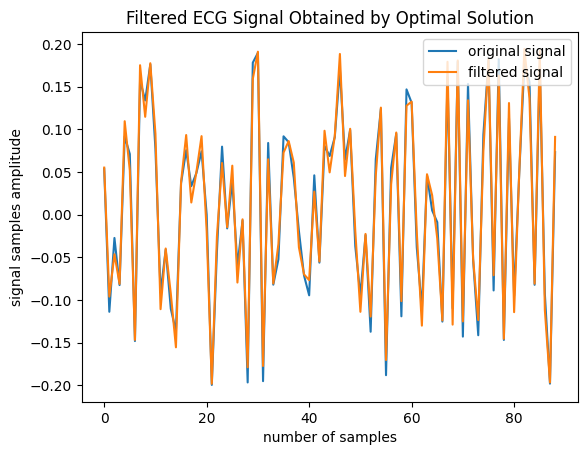

In [5]:
case = "1ordre"
if case == '1ordre':  # case of third order filter calculation
    n = len(t)-1
    w = np.array([0, 0])  # initial values of synaptic weights
    b = 0                 # initial values of baised value
    a = np.zeros(len(t)-1)  # initial value of ADALINE network output
    V = np.array([v[1:90], v[0:89]])  # input signal
    T = t[1:90]  # target signal

 # Minimizing the square of difference between target signal and ADALINE network output
# Optimal solution (see course slide nr. 19)
    Cov_R = np.cov(v[1:90], v[0:89])
    Cov_h = np.dot(V, T.T)/len(t[1:])
    w1 = np.dot(inv(Cov_R), Cov_h.T)
    # simulate the ADALINE for optimal solution on input signals
    a1 = np.dot(w1.T, V)
    e1 = T-a1  # Initial filtered signal values

    plt.figure(2)
    plt.plot(S[1:90])
    plt.plot(e1)
    plt.legend(('original signal', 'filtered signal'), loc='upper right')
    plt.title('Filtered ECG Signal Obtained by Optimal Solution')
    plt.xlabel('number of samples')
    plt.ylabel('signal samples amplitude')
    plt.show()
    e = T-a
    J = []


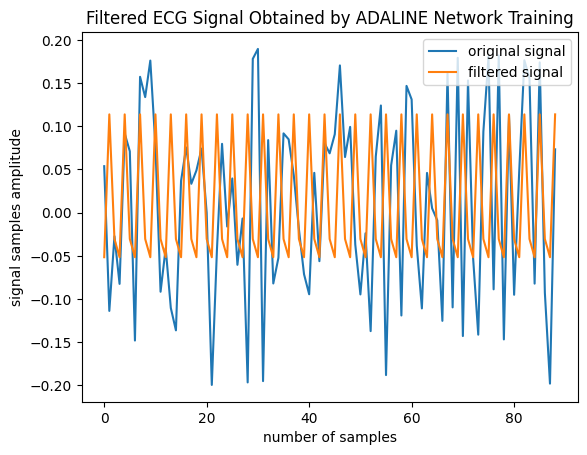

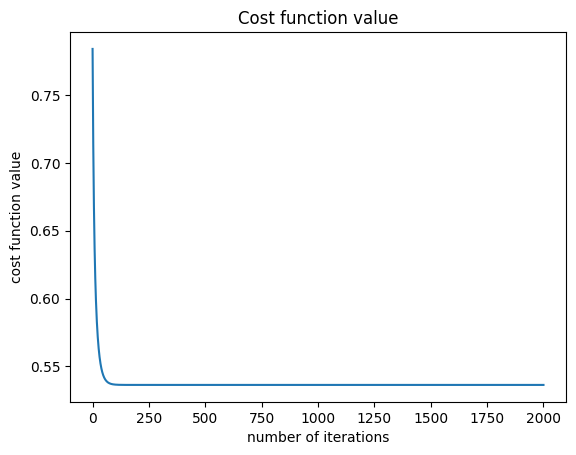

In [9]:
# ADALINE network training
for i in range(1000):
    a = np.dot(w.T, V)+b  # simulate the ADALINE on input signals
    e = T-a  # error signal
    w = w+0.001*np.dot(V, e.T)  # update synaptic weights
    b = b+0.001*np.sum(e)  # update bias value
    J = np.concatenate((J, [0.5*np.sum(np.square(e))]))  # cost function value
    if i == 999:
        plt.figure(3)
        plt.plot(S[1:90])
        plt.plot(a)
        plt.legend(('original signal', 'filtered signal'), loc='upper right')
        plt.title('Filtered ECG Signal Obtained by ADALINE Network Training')
        plt.xlabel('number of samples')
        plt.ylabel('signal samples amplitude')
        plt.show()
        plt.figure(4)
        plt.plot(J)
        plt.title('Cost function value')
        plt.xlabel('number of iterations')
        plt.ylabel('cost function value')
        plt.show()


# First Order Filter Design: ADALINE Design Based on Iterative Solution

- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. **For more details please see course slide nr.23**.
- There is no biaised value **b** considered for ADALINE
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$ and $a(k)=w_{11}v(k)+w_{12}v(k-1)$
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n e(t)\|$, where $n=dim(T)$
- Algorithm:
  \begin{eqnarray}
  w_i(k+1)&=&w_i(k)+2 \alpha e(k)V^T(k) \nonumber \\
  b_i(k+1)&=&b_i(k)+2\alpha e(k) \nonumber
  \end{eqnarray}


# Second Order Filter Design: ADALINE Design based on Iterative Solution

- The optimal solution is obtained by minimizing least mean square (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$.


# Filter Design: ADALINE Design based using KERAS

- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiltered signal $T(k)$ considered as target signal and the output of ADALINE network.
- KERAS allow to define optimization algorithms and paremetters


# Simulate ADALINE

- obtain the synaptic weights from network model via **model.get_weights()** and propagate the input signal to the ADALINE output **$a(t)$** using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$ or $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$ corresponding to first or second order ADALINE flter.


# Simulate ADALINE

- propagate the input signal using KERAS command **model.predict(input_NN)** in order to obtain the ADALINE output **$a(t)$**
